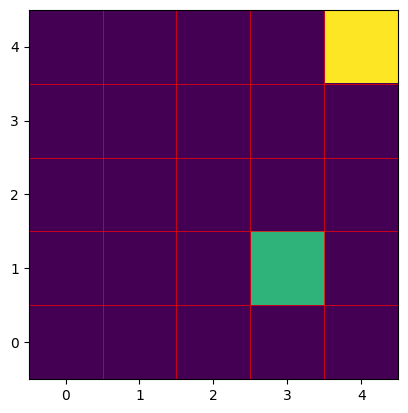

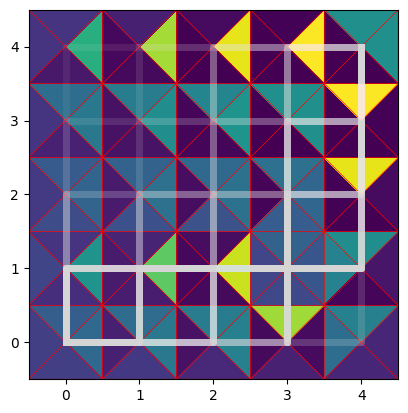

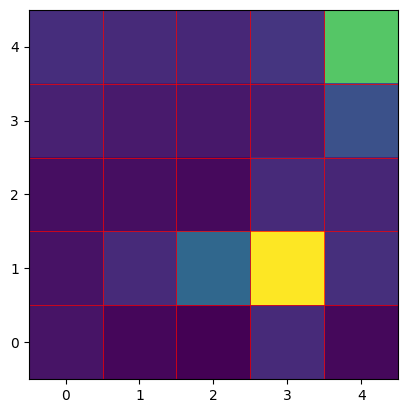

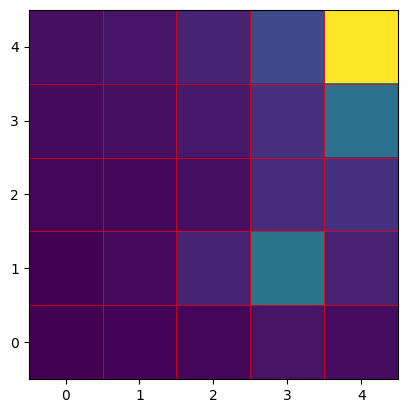

In [1]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.tri as tri


# =============================================================================
# Grid-World Markov Decision Processes (MDPs).
# =============================================================================

class GridWorld:
    """
    Basic deterministic grid world MDP.

    The attribute size specifies both width and height of the world, so a
    world will have size**2 states.

    Args:
        size: The width and height of the world as integer.

    Attributes:
        n_states: The number of states of this MDP.
        n_actions: The number of actions of this MDP.
        p_transition: The transition probabilities as table. The entry
            `p_transition[from, to, a]` contains the probability of
            transitioning from state `from` to state `to` via action `a`.
        size: The width and height of the world.
        actions: The actions of this world as pairs, indicating the
            direction in terms of coordinates.
    """

    def __init__(self, size):
        self.size = size

        self.actions = [(1, 0), (-1, 0), (0, 1), (0, -1)]

        self.n_states = size**2
        self.n_actions = len(self.actions)

        self.p_transition = self._transition_prob_table()

    def state_index_to_point(self, state):
        return state % self.size, state // self.size

    def state_point_to_index(self, state):
        return state[1] * self.size + state[0]

    def state_point_to_index_clipped(self, state):
        s = (max(0, min(self.size - 1, state[0])), max(0, min(self.size - 1, state[1])))
        return self.state_point_to_index(s)

    def state_index_transition(self, s, a):
        s = self.state_index_to_point(s)
        s = s[0] + self.actions[a][0], s[1] + self.actions[a][1]
        return self.state_point_to_index_clipped(s)

    def _transition_prob_table(self):
        table = np.zeros(shape=(self.n_states, self.n_states, self.n_actions))
        s1, s2, a = range(self.n_states), range(self.n_states), range(self.n_actions)
        for sf, st, act in product(s1, s2, a):
            table[sf, st, act] = self._transition_prob(sf, st, act)
        return table

    def _transition_prob(self, s_from, s_to, a):
        fx, fy = self.state_index_to_point(s_from)
        tx, ty = self.state_index_to_point(s_to)
        ax, ay = self.actions[a]

        # deterministic transition defined by action
        if fx + ax == tx and fy + ay == ty:
            return 1.0

        # we can stay at the same state if we would move over an edge
        if fx == tx and fy == ty:
            if not 0 <= fx + ax < self.size or not 0 <= fy + ay < self.size:
                return 1.0

        return 0.0

    def __repr__(self):
        return "GridWorld(size={})".format(self.size)


class IcyGridWorld(GridWorld):
    """
    Grid world MDP similar to Frozen Lake, without holes in the ice.

    Agents slip with probability p_slip, causing the agent to end up in a
    random neighboring state instead of the intended one.

    Args:
        size: The width and height of the world as integer.
        p_slip: The probability of a slip.
    """

    def __init__(self, size, p_slip=0.2):
        self.p_slip = p_slip
        super().__init__(size)

    def _transition_prob(self, s_from, s_to, a):
        fx, fy = self.state_index_to_point(s_from)
        tx, ty = self.state_index_to_point(s_to)
        ax, ay = self.actions[a]

        # intended transition
        if fx + ax == tx and fy + ay == ty:
            return 1.0 - self.p_slip + self.p_slip / self.n_actions

        # slip to neighbors
        if abs(fx - tx) + abs(fy - ty) == 1:
            return self.p_slip / self.n_actions

        # stay at state if edge is hit
        if fx == tx and fy == ty:
            if not 0 <= fx + ax < self.size or not 0 <= fy + ay < self.size:
                # double slip at corners
                if not 0 < fx < self.size - 1 and not 0 < fy < self.size - 1:
                    return 1.0 - self.p_slip + 2.0 * self.p_slip / self.n_actions
                return 1.0 - self.p_slip + self.p_slip / self.n_actions

            # double slip chance at corners inside grid
            if not 0 < fx < self.size - 1 and not 0 < fy < self.size - 1:
                return 2.0 * self.p_slip / self.n_actions

            # single slip at edge
            if not 0 < fx < self.size - 1 or not 0 < fy < self.size - 1:
                return self.p_slip / self.n_actions

            return 0.0

        return 0.0

    def __repr__(self):
        return "IcyGridWorld(size={}, p_slip={})".format(self.size, self.p_slip)


def state_features(world):
    """
    Return an identity feature-matrix.
    """
    return np.identity(world.n_states)


def coordinate_features(world):
    """
    Symmetric features assigning each state a vector where the respective
    coordinate indices are nonzero.
    """
    features = np.zeros((world.n_states, world.size))
    for s in range(world.n_states):
        x, y = world.state_index_to_point(s)
        features[s, x] += 1
        features[s, y] += 1
    return features


# =============================================================================
# Maximum Entropy and Maximum Causal Entropy IRL
# =============================================================================

def feature_expectation_from_trajectories(features, trajectories):
    n_states, n_features = features.shape
    fe = np.zeros(n_features)
    for t in trajectories:
        for s in t.states():
            fe += features[s, :]
    return fe / len(trajectories)


def initial_probabilities_from_trajectories(n_states, trajectories):
    p = np.zeros(n_states)
    for t in trajectories:
        p[t.transitions()[0][0]] += 1.0
    return p / len(trajectories)


def expected_svf_from_policy(p_transition, p_initial, terminal, p_action, eps=1e-5):
    n_states, _, n_actions = p_transition.shape

    p_transition = np.copy(p_transition)
    p_transition[terminal, :, :] = 0.0
    p_transition = [np.array(p_transition[:, :, a]) for a in range(n_actions)]

    d = np.zeros(n_states)
    delta = np.inf
    while delta > eps:
        d_ = [p_transition[a].T.dot(p_action[:, a] * d) for a in range(n_actions)]
        d_ = p_initial + np.array(d_).sum(axis=0)
        delta, d = np.max(np.abs(d_ - d)), d_
    return d


def local_action_probabilities(p_transition, terminal, reward):
    n_states, _, n_actions = p_transition.shape
    er = np.exp(reward)
    p = [np.array(p_transition[:, :, a]) for a in range(n_actions)]

    zs = np.zeros(n_states)
    zs[terminal] = 1.0

    for _ in range(2 * n_states):
        za = np.array([er * p[a].dot(zs) for a in range(n_actions)]).T
        zs = za.sum(axis=1)
    return za / zs[:, None]


def compute_expected_svf(p_transition, p_initial, terminal, reward, eps=1e-5):
    p_action = local_action_probabilities(p_transition, terminal, reward)
    return expected_svf_from_policy(p_transition, p_initial, terminal, p_action, eps)


def irl(p_transition, features, terminal, trajectories, optim, init, eps=1e-4, eps_esvf=1e-5):
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape

    e_features = feature_expectation_from_trajectories(features, trajectories)
    p_initial = initial_probabilities_from_trajectories(n_states, trajectories)

    theta = init(n_features)
    delta = np.inf
    optim.reset(theta)

    while delta > eps:
        theta_old = theta.copy()
        reward = features.dot(theta)
        e_svf = compute_expected_svf(p_transition, p_initial, terminal, reward, eps_esvf)
        grad = e_features - features.T.dot(e_svf)
        optim.step(grad)
        delta = np.max(np.abs(theta_old - theta))

    return features.dot(theta)


def softmax(x1, x2):
    x_max = np.maximum(x1, x2)
    x_min = np.minimum(x1, x2)
    return x_max + np.log(1.0 + np.exp(x_min - x_max))


def local_causal_action_probabilities(p_transition, terminal, reward, discount, eps=1e-5):
    n_states, _, n_actions = p_transition.shape

    if len(terminal) == n_states:
        reward_terminal = np.array(terminal, dtype=float)
    else:
        reward_terminal = -np.inf * np.ones(n_states)
        reward_terminal[terminal] = 0.0

    p = [np.array(p_transition[:, :, a]) for a in range(n_actions)]
    v = -1e200 * np.ones(n_states)

    delta = np.inf
    while delta > eps:
        v_old = v
        q = np.array([reward + discount * p[a].dot(v_old) for a in range(n_actions)]).T
        v = reward_terminal
        for a in range(n_actions):
            v = softmax(v, q[:, a])
        v = np.array(v, dtype=float)
        delta = np.max(np.abs(v - v_old))

    return np.exp(q - v[:, None])


def compute_expected_causal_svf(p_transition, p_initial, terminal, reward, discount,
                                eps_lap=1e-5, eps_svf=1e-5):
    p_action = local_causal_action_probabilities(p_transition, terminal, reward, discount, eps_lap)
    return expected_svf_from_policy(p_transition, p_initial, terminal, p_action, eps_svf)


def irl_causal(p_transition, features, terminal, trajectories, optim, init, discount,
               eps=1e-4, eps_svf=1e-5, eps_lap=1e-5):
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape

    e_features = feature_expectation_from_trajectories(features, trajectories)
    p_initial = initial_probabilities_from_trajectories(n_states, trajectories)

    theta = init(n_features)
    delta = np.inf
    optim.reset(theta)

    while delta > eps:
        theta_old = theta.copy()
        reward = features.dot(theta)
        e_svf = compute_expected_causal_svf(p_transition, p_initial, terminal, reward, discount,
                                            eps_lap, eps_svf)
        grad = e_features - features.T.dot(e_svf)
        optim.step(grad)
        delta = np.max(np.abs(theta_old - theta))

    return features.dot(theta)


# =============================================================================
# Optimizers
# =============================================================================

class Optimizer:
    def __init__(self):
        self.parameters = None

    def reset(self, parameters):
        self.parameters = parameters

    def step(self, grad, *args, **kwargs):
        raise NotImplementedError

    def normalize_grad(self, ord=None):
        return NormalizeGrad(self, ord)


class Sga(Optimizer):
    def __init__(self, lr):
        super().__init__()
        self.lr = lr
        self.k = 0

    def reset(self, parameters):
        super().reset(parameters)
        self.k = 0

    def step(self, grad, *args, **kwargs):
        lr = self.lr if not callable(self.lr) else self.lr(self.k)
        self.k += 1
        self.parameters += lr * grad


class ExpSga(Optimizer):
    def __init__(self, lr, normalize=False):
        super().__init__()
        self.lr = lr
        self.normalize = normalize
        self.k = 0

    def reset(self, parameters):
        super().reset(parameters)
        self.k = 0

    def step(self, grad, *args, **kwargs):
        lr = self.lr if not callable(self.lr) else self.lr(self.k)
        self.k += 1
        self.parameters *= np.exp(lr * grad)
        if self.normalize:
            self.parameters /= self.parameters.sum()


class NormalizeGrad(Optimizer):
    def __init__(self, opt, ord=None):
        super().__init__()
        self.opt = opt
        self.ord = ord

    def reset(self, parameters):
        super().reset(parameters)
        self.opt.reset(parameters)

    def step(self, grad, *args, **kwargs):
        return self.opt.step(grad / np.linalg.norm(grad, self.ord), *args, **kwargs)


def linear_decay(lr0=0.2, decay_rate=1.0, decay_steps=1):
    def _lr(k):
        return lr0 / (1.0 + decay_rate * np.floor(k / decay_steps))
    return _lr


def power_decay(lr0=0.2, decay_rate=1.0, decay_steps=1, power=2):
    def _lr(k):
        return lr0 / (decay_rate * np.floor(k / decay_steps) + 1.0)**power
    return _lr


def exponential_decay(lr0=0.2, decay_rate=0.5, decay_steps=1):
    def _lr(k):
        return lr0 * np.exp(-decay_rate * np.floor(k / decay_steps))
    return _lr


class Initializer:
    def __init__(self):
        pass

    def initialize(self, shape):
        raise NotImplementedError

    def __call__(self, shape):
        return self.initialize(shape)


class Uniform(Initializer):
    def __init__(self, low=0.0, high=1.0):
        super().__init__()
        self.low = low
        self.high = high

    def initialize(self, shape):
        return np.random.uniform(size=shape, low=self.low, high=self.high)


class Constant(Initializer):
    def __init__(self, value=1.0):
        super().__init__()
        self.value = value

    def initialize(self, shape):
        if callable(self.value):
            return np.ones(shape) * self.value(shape)
        else:
            return np.ones(shape) * self.value


# =============================================================================
# Plotting Utilities
# =============================================================================

def plot_transition_probabilities(ax, world, border=None, **kwargs):
    xy = [(x - 0.5, y - 0.5) for y, x in product(range(world.size + 1), range(world.size + 1))]
    xy += [(x, y) for y, x in product(range(world.size), range(world.size))]

    t, v = [], []
    for sy, sx in product(range(world.size), range(world.size)):
        state = world.state_point_to_index((sx, sy))
        state_r = world.state_point_to_index_clipped((sx + 1, sy))
        state_l = world.state_point_to_index_clipped((sx - 1, sy))
        state_t = world.state_point_to_index_clipped((sx, sy + 1))
        state_b = world.state_point_to_index_clipped((sx, sy - 1))

        bl, br = sy * (world.size + 1) + sx, sy * (world.size + 1) + sx + 1
        tl, tr = (sy + 1) * (world.size + 1) + sx, (sy + 1) * (world.size + 1) + sx + 1
        cc = (world.size + 1)**2 + sy * world.size + sx

        t += [(tr, cc, br)]
        t += [(tl, bl, cc)]
        t += [(tl, cc, tr)]
        t += [(bl, br, cc)]

        v += [world.p_transition[state, state_r, 0]]
        v += [world.p_transition[state, state_l, 1]]
        v += [world.p_transition[state, state_t, 2]]
        v += [world.p_transition[state, state_b, 3]]

    x, y = zip(*xy)
    x, y = np.array(x), np.array(y)
    t, v = np.array(t), np.array(v)

    ax.set_aspect('equal')
    ax.set_xticks(range(world.size))
    ax.set_yticks(range(world.size))
    ax.set_xlim(-0.5, world.size - 0.5)
    ax.set_ylim(-0.5, world.size - 0.5)

    p = ax.tripcolor(x, y, t, facecolors=v, vmin=0.0, vmax=1.0, **kwargs)
    if border is not None:
        ax.triplot(x, y, t, **border)
    return p


def plot_state_values(ax, world, values, border, **kwargs):
    p = ax.imshow(np.reshape(values, (world.size, world.size)), origin='lower', **kwargs)
    if border is not None:
        for i in range(0, world.size + 1):
            ax.plot([i - 0.5, i - 0.5], [-0.5, world.size - 0.5], **border)
            ax.plot([-0.5, world.size - 0.5], [i - 0.5, i - 0.5], **border)
    return p


def plot_deterministic_policy(ax, world, policy, **kwargs):
    arrow_direction = [(0.33, 0), (-0.33, 0), (0, 0.33), (0, -0.33)]
    for state in range(world.n_states):
        cx, cy = world.state_index_to_point(state)
        dx, dy = arrow_direction[policy[state]]
        ax.arrow(cx - 0.5 * dx, cy - 0.5 * dy, dx, dy, head_width=0.1, **kwargs)


def plot_stochastic_policy(ax, world, policy, border=None, **kwargs):
    xy = [(x - 0.5, y - 0.5) for y, x in product(range(world.size + 1), range(world.size + 1))]
    xy += [(x, y) for y, x in product(range(world.size), range(world.size))]

    t, v = [], []
    for sy, sx in product(range(world.size), range(world.size)):
        state = world.state_point_to_index((sx, sy))

        bl, br = sy * (world.size + 1) + sx, sy * (world.size + 1) + sx + 1
        tl, tr = (sy + 1) * (world.size + 1) + sx, (sy + 1) * (world.size + 1) + sx + 1
        cc = (world.size + 1)**2 + sy * world.size + sx

        t += [(tr, cc, br)]
        t += [(tl, bl, cc)]
        t += [(tl, cc, tr)]
        t += [(bl, br, cc)]

        v += [policy[state, 0]]
        v += [policy[state, 1]]
        v += [policy[state, 2]]
        v += [policy[state, 3]]

    x, y = zip(*xy)
    x, y = np.array(x), np.array(y)
    t, v = np.array(t), np.array(v)

    ax.set_aspect('equal')
    ax.set_xticks(range(world.size))
    ax.set_yticks(range(world.size))
    ax.set_xlim(-0.5, world.size - 0.5)
    ax.set_ylim(-0.5, world.size - 0.5)

    p = ax.tripcolor(x, y, t, facecolors=v, vmin=0.0, vmax=1.0, **kwargs)
    if border is not None:
        ax.triplot(x, y, t, **border)
    return p


def plot_trajectory(ax, world, trajectory, **kwargs):
    xy = [world.state_index_to_point(s) for s in trajectory.states()]
    x, y = zip(*xy)
    return ax.plot(x, y, **kwargs)


# =============================================================================
# Solver methods for MDPs
# =============================================================================

def value_iteration(p, reward, discount, eps=1e-3):
    n_states, _, n_actions = p.shape
    v = np.zeros(n_states)
    p = [np.matrix(p[:, :, a]) for a in range(n_actions)]

    delta = np.inf
    while delta > eps:
        v_old = v
        q = discount * np.array([p[a] @ v for a in range(n_actions)])
        v = reward + np.max(q, axis=0)[0]
        delta = np.max(np.abs(v_old - v))
    return v


def optimal_policy_from_value(world, value):
    policy = np.array([
        np.argmax([value[world.state_index_transition(s, a)] for a in range(world.n_actions)])
        for s in range(world.n_states)
    ])
    return policy


def stochastic_policy_from_value(world, value, w=lambda x: x):
    value = np.exp(value)
    q = np.array([
        np.array([w(value[world.state_index_transition(s, a)]) for a in range(world.n_actions)])
        for s in range(world.n_states)
    ])
    return q / np.sum(q, axis=1)[:, None]


# =============================================================================
# Trajectories
# =============================================================================

class Trajectory:
    def __init__(self, transitions):
        self._t = transitions

    def transitions(self):
        return self._t

    def states(self):
        # last step also includes the terminal end-state
        return map(lambda x: x[0], self._t + [(self._t[-1][2], 0, 0)])

    def __repr__(self):
        return "Trajectory({})".format(repr(self._t))

    def __str__(self):
        return "{}".format(self._t)


def generate_trajectory(world, policy, start, final):
    state = start
    trajectory = []
    while state not in final:
        action = policy(state)
        next_s = range(world.n_states)
        next_p = world.p_transition[state, :, action]
        next_state = np.random.choice(next_s, p=next_p)
        trajectory += [(state, action, next_state)]
        state = next_state
    return Trajectory(trajectory)


def generate_trajectories(n, world, policy, start, final):
    start_states = np.atleast_1d(start)
    def _generate_one():
        if len(start_states) == world.n_states:
            s = np.random.choice(range(world.n_states), p=start_states)
        else:
            s = np.random.choice(start_states)
        return generate_trajectory(world, policy, s, final)
    return (_generate_one() for _ in range(n))


def policy_adapter(policy):
    return lambda state: policy[state]


def stochastic_policy_adapter(policy):
    return lambda state: np.random.choice([*range(policy.shape[1])], p=policy[state, :])


# =============================================================================
# Main Example
# =============================================================================

def setup_mdp():
    world = IcyGridWorld(size=5, p_slip=0.2)
    reward = np.zeros(world.n_states)
    reward[-1] = 1.0
    reward[8] = 0.65
    terminal = [24]
    return world, reward, terminal


def generate_expert_trajectories(world, reward, terminal):
    n_trajectories = 200
    discount = 0.7
    weighting = lambda x: x**5
    initial = np.zeros(world.n_states)
    initial[0] = 1.0
    value = value_iteration(world.p_transition, reward, discount)
    policy = stochastic_policy_from_value(world, value, w=weighting)
    policy_exec = stochastic_policy_adapter(policy)
    tjs = list(generate_trajectories(n_trajectories, world, policy_exec, initial, terminal))
    return tjs, policy


def maxent_demo(world, terminal, trajectories):
    features = state_features(world)
    init = Constant(1.0)
    optim = ExpSga(lr=linear_decay(lr0=0.2))
    rew = irl(world.p_transition, features, terminal, trajectories, optim, init)
    return rew

def maxent_causal_demo(world, terminal, trajectories, discount=0.7):
    features = state_features(world)
    init = Constant(1.0)
    optim = ExpSga(lr=linear_decay(lr0=0.2))
    rew = irl_causal(world.p_transition, features, terminal, trajectories, optim, init, discount)
    return rew


def main():
    style = {
        'border': {'color': 'red', 'linewidth': 0.5},
    }

    world, reward, terminal = setup_mdp()

    ax = plt.figure(num='Original Reward').add_subplot(111)
    plot_state_values(ax, world, reward, **style)
    plt.draw()

    trajectories, expert_policy = generate_expert_trajectories(world, reward, terminal)

    ax = plt.figure(num='Expert Trajectories and Policy').add_subplot(111)
    plot_stochastic_policy(ax, world, expert_policy, **style)
    for t in trajectories:
        plot_trajectory(ax, world, t, lw=5, color='white', alpha=0.025)
    plt.draw()

    reward_maxent = maxent_demo(world, terminal, trajectories)
    ax = plt.figure(num='MaxEnt Reward').add_subplot(111)
    plot_state_values(ax, world, reward_maxent, **style)
    plt.draw()

    reward_maxcausal = maxent_causal_demo(world, terminal, trajectories)
    ax = plt.figure(num='MaxEnt Reward (Causal)').add_subplot(111)
    plot_state_values(ax, world, reward_maxcausal, **style)
    plt.draw()

    plt.show()


if __name__ == '__main__':
    main()


In [ ]:
import numpy as np
from scipy.optimize import minimize

class Optimizer:
    def __init__(self, lr):
        self.lr = lr
        self.parameters = None

    def reset(self, parameters):
        self.parameters = parameters

    def step(self, grad):
        self.parameters += self.lr * grad

def feature_expectation_from_trajectories(features, trajectories):
    fe = np.zeros(features.shape[1])
    for t in trajectories:
        for s in t.states():
            fe += features[s, :]
    return fe / len(trajectories)

def initial_probabilities_from_trajectories(n_states, trajectories):
    p = np.zeros(n_states)
    for t in trajectories:
        p[t.transitions()[0][0]] += 1.0
    return p / len(trajectories)

def local_action_probabilities(p_transition, terminal, reward):
    n_states, _, n_actions = p_transition.shape
    er = np.exp(reward)
    p = [p_transition[:, :, a] for a in range(n_actions)]
    zs = np.zeros(n_states)
    zs[terminal] = 1.0
    for _ in range(2 * n_states):
        za = np.array([er * p[a].dot(zs) for a in range(n_actions)]).T
        zs = za.sum(axis=1)
    return za / zs[:, None]

def expected_svf_from_policy(p_transition, p_initial, terminal, p_action, eps=1e-5):
    n_states, _, n_actions = p_transition.shape
    pt = np.copy(p_transition)
    pt[terminal, :, :] = 0.0
    pt = [pt[:, :, a] for a in range(n_actions)]
    d = np.zeros(n_states)
    while True:
        d_old = d.copy()
        d_ = [pt[a].T.dot(p_action[:, a] * d) for a in range(n_actions)]
        d_ = p_initial + np.sum(d_, axis=0)
        if np.max(np.abs(d_ - d)) < eps:
            return d_
        d = d_

def compute_expected_svf(p_transition, p_initial, terminal, reward, eps=1e-5):
    p_action = local_action_probabilities(p_transition, terminal, reward)
    return expected_svf_from_policy(p_transition, p_initial, terminal, p_action, eps)

def irl(p_transition, features, terminal, trajectories, optim, init, eps=1e-4, eps_esvf=1e-5):
    e_features = feature_expectation_from_trajectories(features, trajectories)
    p_initial = initial_probabilities_from_trajectories(features.shape[0], trajectories)
    theta = init(features.shape[1])
    optim.reset(theta)
    while True:
        old = theta.copy()
        reward = features.dot(theta)
        e_svf = compute_expected_svf(p_transition, p_initial, terminal, reward, eps_esvf)
        grad = e_features - features.T.dot(e_svf)
        optim.step(grad)
        if np.max(np.abs(old - theta)) < eps:
            break
    return features.dot(theta)

class GridWorld:
    def __init__(self, size):
        self.size = size
        self.n_states = size * size
        self.n_actions = 4
        self.actions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        self.p_transition = self._build_transitions()

    def _build_transitions(self):
        p = np.zeros((self.n_states, self.n_states, self.n_actions))
        for s in range(self.n_states):
            x, y = s % self.size, s // self.size
            for a, (dx, dy) in enumerate(self.actions):
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.size and 0 <= ny < self.size:
                    next_state = ny * self.size + nx
                    p[s, next_state, a] = 1.0
                else:
                    p[s, s, a] = 1.0
        return p

class Trajectory:
    def __init__(self, transitions):
        self._t = transitions

    def transitions(self):
        return self._t

    def states(self):
        return [x[0] for x in self._t] + [self._t[-1][2]]

def generate_trajectory(world, policy, start, terminal):
    state = start
    trajectory = []
    while state not in terminal:
        action = np.random.choice(range(policy.shape[1]), p=policy[state])
        next_state = np.random.choice(range(world.n_states), p=world.p_transition[state, :, action])
        trajectory.append((state, action, next_state))
        state = next_state
    return Trajectory(trajectory)

def generate_trajectories(n, world, policy, start_states, terminal):
    trajectories = []
    for _ in range(n):
        start = np.random.choice(start_states)
        trajectories.append(generate_trajectory(world, policy, start, terminal))
    return trajectories

def softmax_policy(world, values, temperature=1.0):
    policy = np.zeros((world.n_states, world.n_actions))
    for s in range(world.n_states):
        q_values = []
        for a in range(world.n_actions):
            next_states = np.where(world.p_transition[s, :, a] > 0)[0]
            q_value = np.sum(world.p_transition[s, next_states, a] * values[next_states])
            q_values.append(q_value)
        exp_q = np.exp(np.array(q_values) / temperature)
        policy[s] = exp_q / np.sum(exp_q)
    return policy

def main():
    size = 5
    world = GridWorld(size)
    features = np.eye(world.n_states)
    terminal = [world.n_states - 1]
    reward = np.zeros(world.n_states)
    reward[-1] = 1.0

    values = np.random.random(world.n_states)  # Replace with value iteration for accuracy
    policy = softmax_policy(world, values, temperature=0.7)
    start_states = [0]
    trajectories = generate_trajectories(50, world, policy, start_states, terminal)

    optim = Optimizer(lr=0.1)
    init = lambda dim: np.random.uniform(size=dim)

    estimated_weights = irl(world.p_transition, features, terminal, trajectories, optim, init)
    print("Estimated Weights:", estimated_weights)

if __name__ == "__main__":
    main()
